In [1]:
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/aapl_msi_sbux.csv
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv

--2020-03-25 15:54:40--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/aapl_msi_sbux.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24098 (24K) [text/plain]
Saving to: ‘aapl_msi_sbux.csv’

aapl_msi_sbux.csv   100%[===================>]  23.53K  --.-KB/s    in 0.01s   

2020-03-25 15:54:45 (1.98 MB/s) - ‘aapl_msi_sbux.csv’ saved [24098/24098]

--2020-03-25 15:54:46--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response...

# Imort Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [0]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space) # play an epise using a random possible action
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states) # scale states according to states encountered in random play
  return scaler


def maybe_make_dir(directory): # to store trained model and rewards encountered
  if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv('aapl_msi_sbux.csv') 
  return df.values # we will use only the closing price value shape (1259, 3)

# Linear RL Trader

In [0]:
class LinearModel:
  """ A linear regression model """
  def __init__(self, input_dim, n_action): # input size which is the state-dimensionality and the output size which is the size of the action space
    self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
    self.b = np.zeros(n_action)

    # momentum terms
    self.vW = 0
    self.vb = 0

    self.losses = [] # will populate on each step of gradient descent that we do

  def predict(self, X): # takes in a 2-dim array x of size N by D
    # make sure X is N x D
    assert(len(X.shape) == 2)
    return X.dot(self.W) + self.b # returns model prediction x*w + b

  def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is N x D
    assert(len(X.shape) == 2)

    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
    num_values = np.prod(Y.shape)

    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = self.predict(X)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update params
    self.W += self.vW
    self.b += self.vb

    mse = np.mean((Yhat - Y)**2)
    self.losses.append(mse)

  def load_weights(self, filepath):
    npz = np.load(filepath)
    self.W = npz['W']
    self.b = npz['b']

  def save_weights(self, filepath):
    np.savez(filepath, W=self.W, b=self.b)

In [0]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [0]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = LinearModel(state_size, action_size)

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def train(self, state, action, reward, next_state, done):
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

    target_full = self.model.predict(state)
    target_full[0, action] = target

    # Run one training step
    self.model.sgd(state, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)

In [0]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return info['cur_val']

In [0]:
  # config
  models_folder = 'linear_rl_trader_models'
  rewards_folder = 'linear_rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000

In [0]:
  parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  args = parser#.parse_args()
  args.mode='train' #'test'

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if args.mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')

episode: 1/2000, episode end value: 32336.92, duration: 0:00:00.206960
episode: 2/2000, episode end value: 38413.90, duration: 0:00:00.151658
episode: 3/2000, episode end value: 33775.37, duration: 0:00:00.134113
episode: 4/2000, episode end value: 31164.34, duration: 0:00:00.137264
episode: 5/2000, episode end value: 44139.13, duration: 0:00:00.135911
episode: 6/2000, episode end value: 40405.99, duration: 0:00:00.142072
episode: 7/2000, episode end value: 37627.00, duration: 0:00:00.140848
episode: 8/2000, episode end value: 41917.72, duration: 0:00:00.128110
episode: 9/2000, episode end value: 47212.12, duration: 0:00:00.143404
episode: 10/2000, episode end value: 37023.40, duration: 0:00:00.130991
episode: 11/2000, episode end value: 53551.15, duration: 0:00:00.145155
episode: 12/2000, episode end value: 42478.89, duration: 0:00:00.131348
episode: 13/2000, episode end value: 51240.26, duration: 0:00:00.145428
episode: 14/2000, episode end value: 46425.10, duration: 0:00:00.134804
e

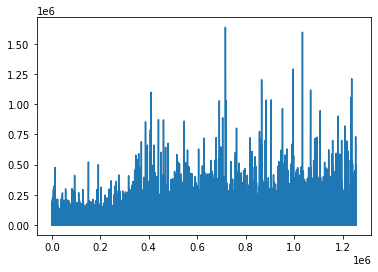

In [15]:
  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, args.mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if args.mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

    # plot losses
    plt.plot(agent.model.losses)
    plt.show()

In [0]:
# save portfolio value for each episode
np.save(f'{rewards_folder}/{args.mode}.npy', portfolio_value)

average reward: 49025.10, min: 20315.94, max: 95409.69


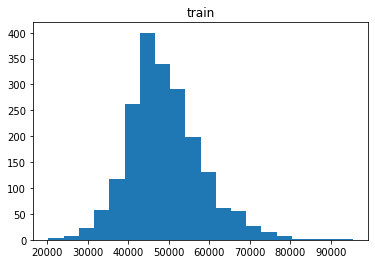

In [19]:
a = np.load(f'linear_rl_trader_rewards/{args.mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

plt.hist(a, bins=20)
plt.title(args.mode)
plt.show()

**Baseline Linear Trader RL**

By setting epsilon to 1.0 we can build a baseline linear trader.


In [0]:
  # config
  models_folder = 'baseline_linear_rl_trader_models'
  rewards_folder = 'baseline_linear_rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000

In [0]:
  parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  args = parser#.parse_args()
  args.mode='train' #'test'

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if args.mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/baseline_scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1! (we set to 1 to establish baseline)
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 1.0 #0.01

    # load trained weights
    agent.load(f'{models_folder}/baseline_linear.npz')

episode: 1/2000, episode end value: 34846.66, duration: 0:00:00.228251
episode: 2/2000, episode end value: 41338.19, duration: 0:00:00.156255
episode: 3/2000, episode end value: 39555.59, duration: 0:00:00.155528
episode: 4/2000, episode end value: 36405.70, duration: 0:00:00.149394
episode: 5/2000, episode end value: 38706.26, duration: 0:00:00.158861
episode: 6/2000, episode end value: 36280.36, duration: 0:00:00.144697
episode: 7/2000, episode end value: 41416.53, duration: 0:00:00.164792
episode: 8/2000, episode end value: 36107.80, duration: 0:00:00.150916
episode: 9/2000, episode end value: 36900.49, duration: 0:00:00.155503
episode: 10/2000, episode end value: 29195.60, duration: 0:00:00.151330
episode: 11/2000, episode end value: 28493.13, duration: 0:00:00.175120
episode: 12/2000, episode end value: 44566.18, duration: 0:00:00.152151
episode: 13/2000, episode end value: 33693.53, duration: 0:00:00.155193
episode: 14/2000, episode end value: 37248.27, duration: 0:00:00.156120
e

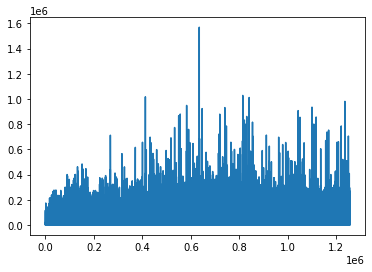

In [17]:
  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, args.mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if args.mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/baseline_linear.npz')

    # save the scaler
    with open(f'{models_folder}/baseline_scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

    # plot losses
    plt.plot(agent.model.losses)
    plt.show()

In [0]:
# save portfolio value for each episode
np.save(f'{rewards_folder}/baseline_'+{args.mode}.npy', portfolio_value)

average reward: 53986.20, min: 28493.13, max: 89061.48


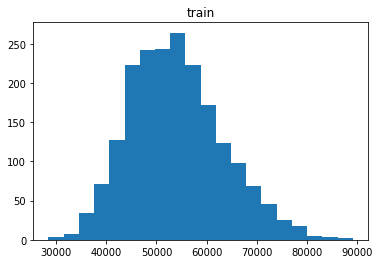

In [19]:
a = np.load(f'baseline_linear_rl_trader_rewards/{args.mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

plt.hist(a, bins=20)
plt.title(args.mode)
plt.show()

# MLP RL Trader

In [0]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break
      
  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

In [0]:
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
### The experience replay memory ###
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])

In [0]:
def mlp(input_dim, n_action, n_hidden_layers=1, hidden_dim=32):
  """ A multi-layer perceptron """

  # input layer
  i = Input(shape=(input_dim,))
  x = i

  # hidden layers
  for _ in range(n_hidden_layers):
    x = Dense(hidden_dim, activation='relu')(x)
  
  # final layer
  x = Dense(n_action)(x)

  # make the model
  model = Model(i, x)

  model.compile(loss='mse', optimizer='adam')
  print((model.summary()))
  return model

In [0]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [0]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = ReplayBuffer(state_size, action_size, size=500)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = mlp(state_size, action_size)


  def update_replay_memory(self, state, action, reward, next_state, done):
    self.memory.store(state, action, reward, next_state, done)


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def replay(self, batch_size=32):
    # first check if replay buffer contains enough data
    if self.memory.size < batch_size:
      return

    # sample a batch of data from the replay memory
    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    actions = minibatch['a']
    rewards = minibatch['r']
    next_states = minibatch['s2']
    done = minibatch['d']

    # Calculate the tentative target: Q(s',a)
    target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)

    # With the Keras API, the target (usually) must have the same
    # shape as the predictions.
    # However, we only need to update the network for the actions
    # which were actually taken.
    # We can accomplish this by setting the target to be equal to
    # the prediction for all values.
    # Then, only change the targets for the actions taken.
    # Q(s,a)
    target_full = self.model.predict(states)
    target_full[np.arange(batch_size), actions] = target

    # Run one training step
    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)

In [0]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val']

In [0]:
  # config
  models_folder = 'rl_trader_models'
  rewards_folder = 'rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000


  #parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  #args = parser.parse_args()

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

In [31]:
  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 27)                891       
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if args.mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01

    # load trained weights
    agent.load(f'{models_folder}/dqn.h5')

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, args.mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if args.mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/dqn.h5')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

episode: 1/2000, episode end value: 28640.45, duration: 0:00:03.358329
episode: 2/2000, episode end value: 32701.19, duration: 0:00:02.946162
episode: 3/2000, episode end value: 27753.49, duration: 0:00:02.991159
episode: 4/2000, episode end value: 24181.64, duration: 0:00:02.895650
episode: 5/2000, episode end value: 41667.90, duration: 0:00:03.021466
episode: 6/2000, episode end value: 31852.06, duration: 0:00:03.102652
episode: 7/2000, episode end value: 30580.06, duration: 0:00:03.237500
episode: 8/2000, episode end value: 46284.85, duration: 0:00:02.946727
episode: 9/2000, episode end value: 35485.40, duration: 0:00:02.957197
episode: 10/2000, episode end value: 22725.37, duration: 0:00:02.979138
episode: 11/2000, episode end value: 33955.25, duration: 0:00:02.966151
episode: 12/2000, episode end value: 30493.04, duration: 0:00:02.942868
episode: 13/2000, episode end value: 36998.51, duration: 0:00:02.946922
episode: 14/2000, episode end value: 48816.57, duration: 0:00:02.940739
e

In [0]:
# save portfolio value for each episode
np.save(f'{rewards_folder}/{args.mode}.npy', portfolio_value)

average reward: 69917.36, min: 22598.87, max: 107571.42


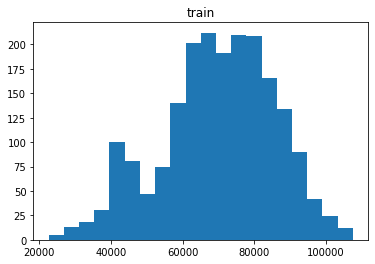

In [35]:
a = np.load(f'rl_trader_rewards/{args.mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

plt.hist(a, bins=20)
plt.title(args.mode)
plt.show()

# Baseline MLP RL Trader

To compare our agents to a baseline trader that takes completely random actions it is equivalent to setting epsilon = 1. 

In [0]:
  # config
  models_folder = 'baseline_rl_trader_models'
  rewards_folder = 'baseline_rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000

  #parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  #args = parser.parse_args()

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

In [0]:
  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

In [28]:
  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if args.mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/baseline_scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1! (we set epsilon to 1 to establish baseline MLP trader)
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 1.0 #0.01

    # load trained weights
    agent.load(f'{models_folder}/baseline_dqn.h5')

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, args.mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if args.mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/baseline_dqn.h5')

    # save the scaler
    with open(f'{models_folder}/baseline_scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
episode: 1/2000, episode end value: 40688.72, duration: 0:00:00.166257
episode: 2/2000, episode end value: 38802.53, duration: 0:00:00.141559
episode: 3/2000, episode end value: 38986.21, duration: 0:00:00.169014
episode: 4/2000, episode end value: 36406.44, duration: 0:00:00.163137
episode: 5/2000, episode end value: 38122.36, duration: 0:00:00.146705
episode: 6/2000, episode end value: 37583.85, duration: 0:00:00.163509
episode: 7/2000, episode end value: 41128.72, duration: 0:00:00.176300
episode: 8/2000, episode end value: 40397.52, duration: 0:00:00.171199
episode: 9/2000, episode end value: 38849.77, duration: 0:00:00.141666
episode: 10/2000, episode end value: 41557.39, duration: 0:00:00.169495
episode: 11/2000, episode end value: 44459.39, duration: 0:00:00.185238
episode: 12/2000, episode end value: 43883.18, duration: 0:00:00.201196
episode: 13/2000, episode end value: 44597.87, dur

In [0]:
# save portfolio value for each episode
np.save(f'{rewards_folder}/baseline_{args.mode}.npy', portfolio_value)

average reward: 51596.17, min: 27261.83, max: 86727.85
ERROR! Session/line number was not unique in database. History logging moved to new session 62


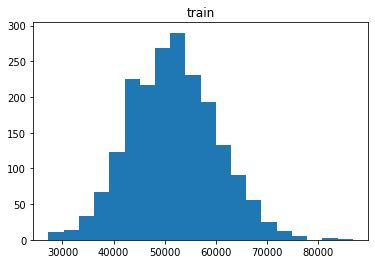

In [31]:
a = np.load(f'baseline_rl_trader_rewards/baseline_{args.mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

plt.hist(a, bins=20)
plt.title(args.mode)
plt.show()

If most of the distribution is above the initial investment would mean the strategy is working on average on making profit, but there is still a not-insignificant chance of losing money. Lower tail end of the distribution means the we lost money in the trade and this happens with a small but non-significant probability.

**Agent comparisons**
The RL agent can beat the random actions most of the time, but still sensitive to hyper-parameters. The probability of loosing money is lower and the floor is just under the initial investment. 

Note if we use *returns* instead of *prices* the signal should be more stationary and we should be using values that don't change significant over time.